In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Variable
from torchsummary import summary

from torchvision.utils import save_image
from IPython.core.display import Image, display

import numpy as np
import matplotlib.pyplot as plt
from vae import VAE

%load_ext autoreload
%autoreload 2

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
bsz = 200
epochs = 500
seqlen = 16

z_size = 32
n_hidden = 256
n_gaussians = 5

In [4]:
z = torch.from_numpy(np.load('z.npy'))
z = z.view(bsz, -1, z.size(1)).to(device)
z.shape

torch.Size([200, 150, 32])

In [5]:
# Truncated backpropagation
def detach(states):
    return [state.detach() for state in states] 

In [6]:
class MDNRNN(nn.Module):
    def __init__(self, z_size, n_hidden=256, n_gaussians=5, n_layers=1):
        super(MDNRNN, self).__init__()

        self.z_size = z_size
        self.n_hidden = n_hidden
        self.n_gaussians = n_gaussians
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(z_size, n_hidden, n_layers, batch_first=True)
        self.fc1 = nn.Linear(n_hidden, n_gaussians*z_size)
        self.fc2 = nn.Linear(n_hidden, n_gaussians*z_size)
        self.fc3 = nn.Linear(n_hidden, n_gaussians*z_size)
        
    def get_mixture_coef(self, y):
        rollout_length = y.size(1)
        pi, mu, sigma = self.fc1(y), self.fc2(y), self.fc3(y)
        
        pi = pi.view(-1, rollout_length, self.n_gaussians, self.z_size)
        mu = mu.view(-1, rollout_length, self.n_gaussians, self.z_size)
        sigma = sigma.view(-1, rollout_length, self.n_gaussians, self.z_size)
        
        pi = F.softmax(pi, 2)
        sigma = torch.exp(sigma)
        return pi, mu, sigma
        
        
    def forward(self, x, h):
        # Forward propagate LSTM
        y, (h, c) = self.lstm(x, h)
        pi, mu, sigma = self.get_mixture_coef(y)
        return (pi, mu, sigma), (h, c)
    
    def init_hidden(self, bsz):
        return (torch.zeros(self.n_layers, bsz, self.n_hidden).to(device),
                torch.zeros(self.n_layers, bsz, self.n_hidden).to(device))

In [17]:
model = MDNRNN(z_size, n_hidden).to(device)
# model.load_state_dict(torch.load('rnn.torch', map_location='cpu'))

In [8]:
# inputs = z[:bsz, :seqlen, :]
# (pi, mu, sigma), (h, c) = model(inputs, model.init_hidden(bsz))
# inputs.shape, pi.shape

In [9]:
def mdn_loss_fn(y, pi, mu, sigma):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(y))
    loss = torch.sum(loss * pi, dim=2)
    loss = -torch.log(loss)
    return loss.mean()

In [10]:
def criterion(y, pi, mu, sigma):
    y = y.unsqueeze(2)
    return mdn_loss_fn(y, pi, mu, sigma)

In [19]:
optimizer = torch.optim.Adam(model.parameters())

In [46]:
# Train the model
for epoch in range(epochs):
    # Set initial hidden and cell states
    hidden = model.init_hidden(bsz)
    
    for i in range(0, z.size(1) - seqlen, seqlen):
        # Get mini-batch inputs and targets
        inputs = z[:, i:i+seqlen, :]
        targets = z[:, (i+1):(i+1)+seqlen, :]
        
        # Forward pass
        hidden = detach(hidden)
        (pi, mu, sigma), hidden = model(inputs, hidden)
        loss = criterion(targets, pi, mu, sigma)
        
        # Backward and optimize
        model.zero_grad()
        loss.backward()
        # clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
    if epoch % 100 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'
               .format(epoch, epochs, loss.item()))

Epoch [0/500], Loss: -1.2711
Epoch [100/500], Loss: -1.3434
Epoch [200/500], Loss: -1.3428
Epoch [300/500], Loss: -1.3833
Epoch [400/500], Loss: -1.4378


In [10]:
# np.linalg.norm(z[0, 0, :].cpu().data - z1[0, :, :].cpu().data, axis=1)
# np.linalg.norm(inputs.cpu().data - targets.cpu().data)

### RNN prediction
There are 5 modes of gaussians. Below is next true sample and 5 modes of predictions

In [22]:
vae = VAE(image_channels=3).to(device)
vae.load_state_dict(torch.load('vae.torch', map_location='cpu'))

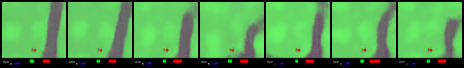

In [68]:
zero = np.random.randint(z.size(0))
one = np.random.randint(z.size(1))
x = z[zero:zero+1, one:one+1, :]
y = z[zero:zero+1, one+1:one+2, :]

hidden = model.init_hidden(1)
(pi, mu, sigma), _ = model(x, hidden)

y_preds = [torch.normal(mu, sigma)[:, :, i, :] for i in range(n_gaussians)]

compare_x = vae.decode(torch.cat([x, y] + y_preds))

# compare_x = vae.decode(z_out)
save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=1000, unconfined=True))